# Data Acquisition

### Import Dependencies

In [3]:
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
import time
import pandas as pd
from datetime import datetime

In [4]:
def get_jobs(keyword, num_jobs, verbose, path, slp_time):
    '''Gathers jobs as a dataframe, scraped from Glassdoor'''

    # Initializing the webdriver
    options = webdriver.ChromeOptions()

    # Uncomment the line below if you'd like to scrape without a new Chrome window every time.
    # options.add_argument('headless')

    # Change the path to where chromedriver is in your home folder.
    driver = webdriver.Chrome(executable_path=path, options=options)
    driver.set_window_size(1120, 1000)
    
    url = 'https://www.glassdoor.co.uk/Job/uk-' + keyword + '-jobs-SRCH_IL.0,2_IN2_KO3,17.htm'
#     url = 'https://www.glassdoor.com/Job/jobs.htm?sc.keyword="' + keyword + '"&locT=C&locId=1147401&locKeyword=San%20Francisco,%20CA&jobType=all&fromAge=-1&minSalary=0&includeNoSalaryJobs=true&radius=100&cityId=-1&minRating=0.0&industryId=-1&sgocId=-1&seniorityType=all&companyId=-1&employerSizes=0&applicationType=0&remoteWorkType=0'
    driver.get(url)
    jobs = []

    while len(jobs) < num_jobs:  # If true, should be still looking for new jobs.

        # Let the page load. Change this number based on your internet speed.
        # Or, wait until the webpage is loaded, instead of hardcoding it.
        time.sleep(slp_time)

        # Test for the "Sign Up" prompt and get rid of it.
        try:
            driver.find_element_by_xpath('.//li[@data-selected="true"]').click()
        except ElementClickInterceptedException:
            pass

        time.sleep(0.1)

        try:
            driver.find_element_by_class_name("modal_closeIcon").click() # clicking to the X.
        except NoSuchElementException:
            pass
        
        #Removing the cookies banner
        try:
            driver.find_element_by_id("onetrust-accept-btn-handler").click()
        except:
            pass
        
        # Going through each job in this page
        job_buttons = driver.find_elements_by_class_name(
            "react-job-listing")  # jl for Job Listing. These are the buttons we're going to click.

        for job_button in job_buttons:

            print("Progress: {}".format("" + str(len(jobs)) + "/" + str(num_jobs)))
            if len(jobs) >= num_jobs:
                break

            job_button.click() 
            time.sleep(1)
            collected_successfully = False

            while not collected_successfully:
                try:
                    location = job_button.get_attribute("data-job-loc")
                    job_title = job_button.get_attribute("data-normalize-job-title")
                    job_description = driver.find_element_by_xpath('//*[@id="JobDescriptionContainer"]').text
                    company_name = driver.find_element_by_css_selector(".css-87uc0g.e1tk4kwz1").text
                    collected_successfully = True
                    
                except Exception as e:
                    print(e)
                    time.sleep(5)
        
            try:
                salary_estimate = driver.find_element_by_xpath('//*[@id="JDCol"]/div/article/div/div[1]/div/div/div[1]/div[3]/div[1]/div[4]/span').text
    
            except NoSuchElementException:
                salary_estimate = '-1'  # You need to set a "not found value. It's important."

            try:
#                 rating = driver.find_element_by_xpath('.//span[@class="rating"]').text
                
                rating = driver.find_element_by_css_selector("span[data-test='detailRating']").text
            except NoSuchElementException:
                rating = -1  # You need to set a "not found value. It's important."

            # Printing for debugging
            if verbose:
                print("Job Title: {}".format(job_title))
                print("Salary Estimate: {}".format(salary_estimate))
                print("Job Description: {}".format(job_description[:500]))
                print("Rating: {}".format(rating))
                print("Company Name: {}".format(company_name))
                print("Location: {}".format(location))

            try:

                try:
                    size = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[1]/span[2]').text
                    
                except NoSuchElementException:
                    size = -1

                try:
                    founded = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[2]/span[2]').text
                except NoSuchElementException:
                    founded = -1

                try:
                    type_of_ownership = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[3]/span[2]').text
                except NoSuchElementException:
                    type_of_ownership = -1

                try:        
                    industry = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[4]/span[2]').text
                except NoSuchElementException:
                    industry = -1

                try:
                    sector = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[5]/span[2]').text
                except NoSuchElementException:
                    sector = -1

                try:
                    revenue = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[6]/span[2]').text
                except NoSuchElementException:
                    revenue = -1

            except NoSuchElementException:  # Rarely, some job postings do not have the "Company" tab.
                size = -1
                founded = -1
                type_of_ownership = -1
                industry = -1
                sector = -1
                revenue = -1

            if verbose:
                print("Size: {}".format(size))
                print("Founded: {}".format(founded))
                print("Type of Ownership: {}".format(type_of_ownership))
                print("Industry: {}".format(industry))
                print("Sector: {}".format(sector))
                print("Revenue: {}".format(revenue))
                print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            jobs.append({"Job Title": job_title,
                         "Salary Estimate": salary_estimate,
                         "Job Description": job_description,
                         "Rating": rating,
                         "Company Name": company_name,
                         "Location": location,
                         "Size": size,
                         "Founded": founded,
                         "Type of ownership": type_of_ownership,
                         "Industry": industry,
                         "Sector": sector,
                         "Revenue": revenue
                         })
            # add job to jobs

        # Clicking on the "next page" button
        try:
            driver.find_element_by_xpath('.//li[@class="next"]//a').click()
        except NoSuchElementException:
            print("Scraping terminated before reaching target number of jobs. Needed {}, got {}.".format(num_jobs,
                                                                                                         len(jobs)))
            break

    return pd.DataFrame(jobs)  # This line converts the dictionary object into a pandas DataFrame.

In [5]:
path = "../chromedriver/chromedriver.exe"

df = get_jobs('data-scientist', 10, False, path, 7)

df.head(10)

Progress: 0/10
Progress: 1/10
Progress: 2/10
Progress: 3/10
Progress: 4/10
Progress: 5/10
Progress: 6/10
Progress: 7/10
Progress: 8/10
Progress: 9/10
Progress: 10/10
Scraping terminated before reaching target number of jobs. Needed 10, got 10.


In [8]:
df.to_csv("glassdoor_jobs.csv", index=False)

# Data Cleaning

### Parse Data & Feature Engineering




In [90]:
# Make new columns for hourly or employed provided salaries
df = pd.read_csv("glassdoor_jobs.csv")

df['Hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['Employer Provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)

# Remove rows without salary records
df= df[df['Salary Estimate'] != "-1"]

# Remove any text and pound sign symbols from the cells
salary = df["Salary Estimate"].apply(lambda x: x.split('(')[0])
minus_kd = salary.apply(lambda x: x.replace('K', "").replace("£",""))

min_hr = minus_kd.apply(lambda x: x.lower().replace('per hour','').replace('employer provided salary',''))

df['Min Salary'] = min_hr.apply(lambda x: int(x.split('-')[0]))
df['Max Salary'] = min_hr.apply(lambda x: int(x.split('-')[1]))
df['Average Salary'] = (df['Max Salary'] + df['Min Salary'])/2

# Company name with text only 
df['Company Name'] = df['Company Name'].apply(lambda x: x.splitlines()[0])
                                          
# Country field
df['Country'] = df['Location'].apply(lambda x: x.split(',')[1])

# Age of company
df['Company Age'] = df['Founded'].apply(lambda x: x if x < 0 else (datetime.now().year - x))

# Parsing of job description (python, SQL, AWS, Spark, Excel, etc)
df['Python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['SQL'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
df['AWS'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df['Spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['Excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'
    
def seniority(title):
    senior_keywords = ['sr', 'senior', 'lead', 'principal']
    junior_keywords = ['jr', 'junior']
    if any(x in title.lower() for x in senior_keywords):  
        return 'senior'
    elif any(x in title.lower() for x in junior_keywords):
        return 'junior'
    else:
        return 'na'

df['Job Simplified'] = df['Job Title'].apply(title_simplifier)
df['Seniority'] = df['Job Description'].apply(seniority)
df['Description Length'] = df['Job Description'].apply(lambda x: len(x))

# Convert hourly wage to annual if required
df['Min Salary'] = df.apply(lambda x: x['Min Salary']*2 if x['Hourly'] == 1 else x['Min Salary'], axis=1)
df['Max Salary'] = df.apply(lambda x: x['Max Salary']*2 if x['Hourly'] == 1 else x['Max Salary'], axis=1)    

df.to_csv('salary_data_cleaned.csv')
df

,Company Name,Founded,Industry,Job Description,Job Title,Location,Rating,Revenue,Salary Estimate,Sector,...,Country,Company Age,Python,SQL,AWS,Spark,Excel,Job Simplified,Seniority,Description Length
0,CGI,1976,Consulting,Job Description Senior Data Scientist\n\nPosit...,Senior Data Scientist,"Reading, England",3.7,$10+ billion (USD),£50K - £65K (Glassdoor Est.),Business Service,...,England,45,0,0,0,0,0,data scientist,senior,1612
1,Sage,1981,Computer Hardware & Software,Advert\nPeople make Sage great. From our colle...,Senior Data Scientist,"London, England",4.3,$1 to $2 billion (USD),£51K - £61K (Glassdoor Est.),Information Technology,...,England,40,0,0,0,0,0,data scientist,na,1284
3,Yara,1905,Chemical Manufacturing,About the Unit\nYara delivers solutions for su...,Research Scientist,"Leeds, England",4.1,$10+ billion (USD),£25K - £35K (Glassdoor Est.),Manufacturing,...,England,116,0,0,0,0,0,na,na,906
4,PsiOxus Therapeutics Ltd,-1,-1,PsiOxus Therapeutics Ltd is an award-winning U...,Senior Research Scientist,"Abingdon, England",-1.0,-1,£42K - £65K (Glassdoor Est.),-1,...,England,-1,0,0,0,0,0,na,senior,916
5,FutureLearn Ltd,2012,Education Training Service,We are currently looking to recruit an experie...,Data Scientist,"London, England",3.4,Unknown / Non-Applicable,£34K - £40K (Glassdoor Est.),Education,...,England,9,1,0,1,1,0,data scientist,senior,3489
7,Funding Circle UK,2010,Lending,About Us\nWe want to help small businesses win...,Data Scientist,"London, England",3.9,$50 to $100 million (USD),£51K - £66K (Glassdoor Est.),Finance,...,England,11,0,0,0,0,0,data scientist,senior,728
8,Conrad Energy,-1,-1,Quantitative Analyst/Data Scientist\nThe quant...,Quantitative Analyst,"Abingdon, England",-1.0,-1,£38K - £72K (Glassdoor Est.),-1,...,England,-1,0,0,0,0,0,analyst,senior,1254
9,QVC,1986,"Department, Clothing, & Shoe Shops",QVC is so much more than a retailer. It’s a br...,Data Engineer,"London, England",3.5,$5 to $10 billion (USD),£43K - £58K (Glassdoor Est.),Retail,...,England,35,0,0,0,0,0,data engineer,senior,620


# Exploratory Data Analysis 

In [5]:
df = pd.read_csv("salary_data_cleaned.csv")
df.drop("Unnamed: 0",axis=1)
df.describe()

,Unnamed: 0,Founded,Rating,Hourly,Employer Provided,Min Salary,Max Salary,Average Salary,Company Age,Python,SQL,AWS,Spark,Excel,Description Length
count,8.000000,8.000000,8.000000,8.0,8.0,8.000000,8.000000,8.000000,8.00000,8.000000,8.0,8.000000,8.000000,8.0,8.000000
mean,4.625000,1483.500000,2.612500,0.0,0.0,41.750000,57.750000,49.750000,31.75000,0.125000,0.0,0.125000,0.125000,0.0,1351.125000
std,3.248626,916.844433,2.249087,0.0,0.0,9.223417,13.199026,10.491493,38.62919,0.353553,0.0,0.353553,0.353553,0.0,922.945818
min,0.000000,-1.000000,-1.000000,0.0,0.0,25.000000,35.000000,30.000000,-1.00000,0.000000,0.0,0.000000,0.000000,0.0,620.000000
25%,2.500000,1428.500000,2.300000,0.0,0.0,37.000000,53.500000,47.125000,6.50000,0.000000,0.0,0.000000,0.000000,0.0,861.500000
50%,4.500000,1978.500000,3.600000,0.0,0.0,42.500000,63.000000,54.250000,23.00000,0.000000,0.0,0.000000,0.000000,0.0,1085.000000
75%,7.250000,1992.000000,3.950000,0.0,0.0,50.250000,65.250000,56.375000,41.25000,0.000000,0.0,0.000000,0.000000,0.0,1366.000000
max,9.000000,2012.000000,4.300000,0.0,0.0,51.000000,72.000000,58.500000,116.00000,1.000000,0.0,1.000000,1.000000,0.0,3489.000000


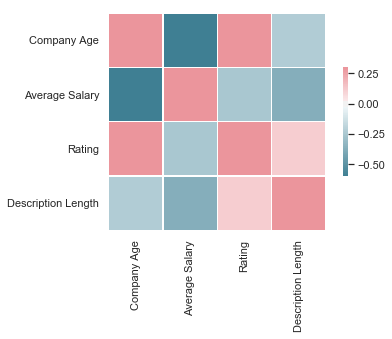

In [10]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)
sns.set()

cmap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(df[['Company Age', 'Average Salary', 'Rating', 'Description Length']].corr(), vmax=.3,
           center=0, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

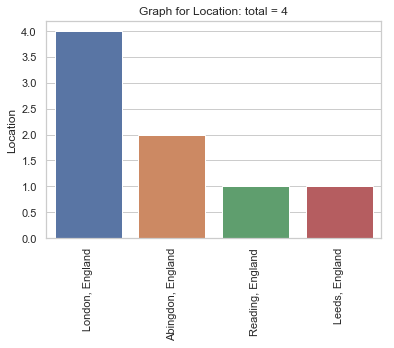

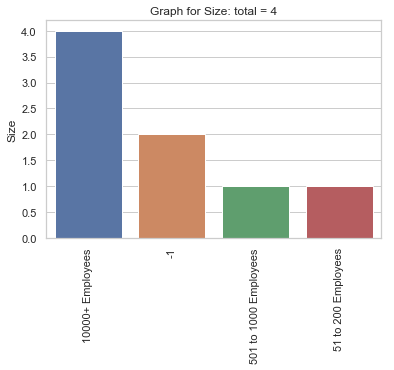

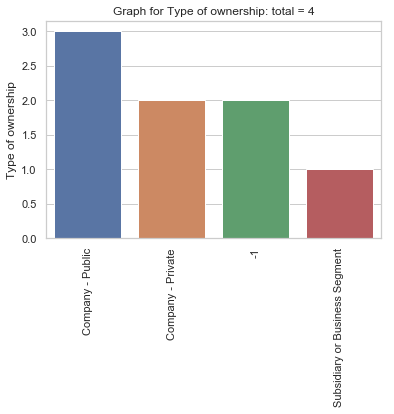

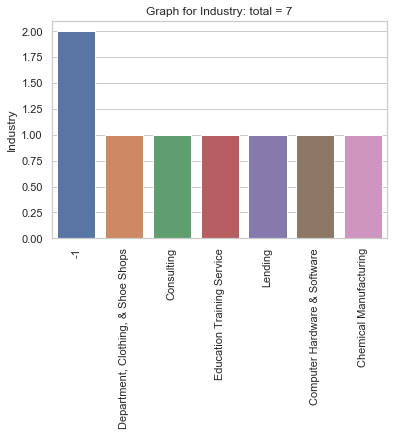

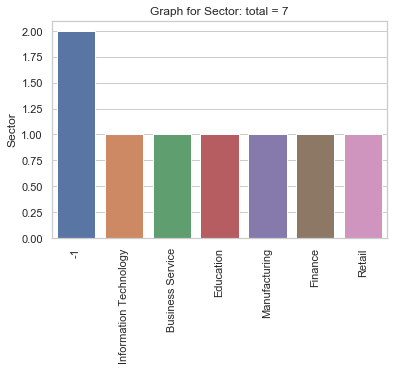

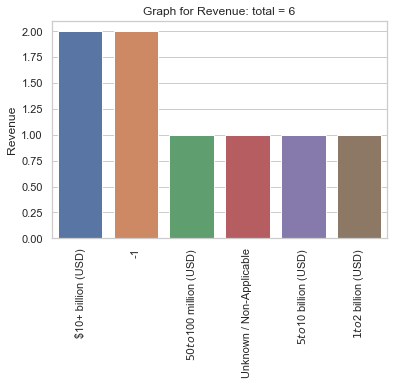

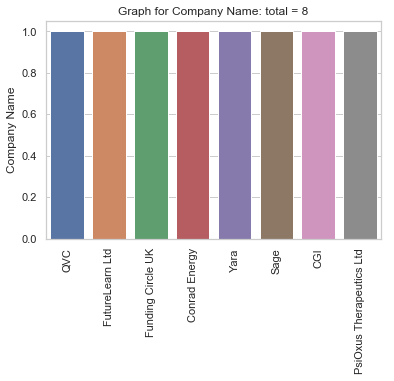

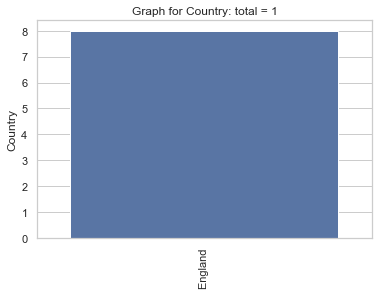

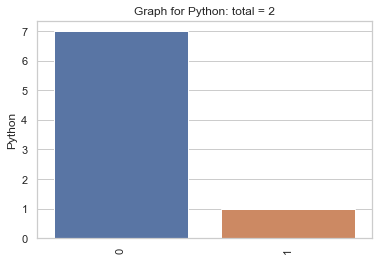

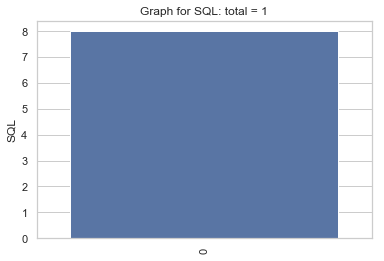

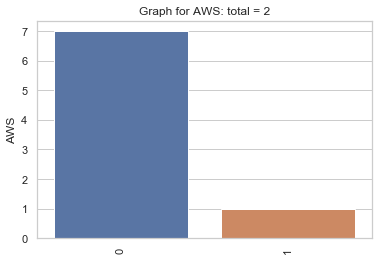

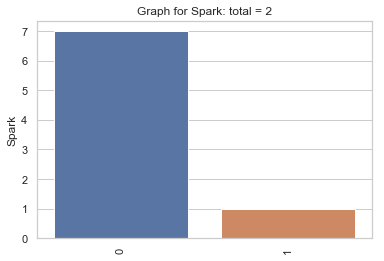

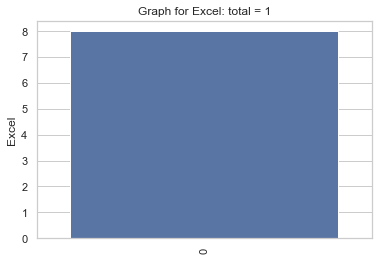

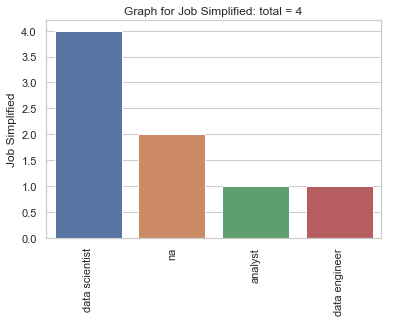

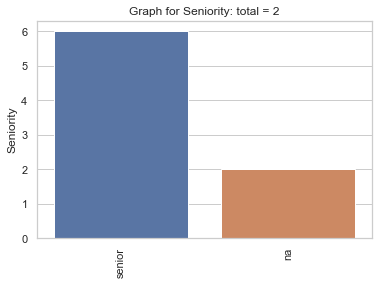

In [28]:
# Extract categorical data
df_cat = df[['Location', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Company Name', 'Country',
    'Python', 'SQL', 'AWS', 'Spark', 'Excel', 'Job Simplified', 'Seniority']]

for category in df_cat.columns:
    cat_num = df_cat[category].value_counts()
    plt.figure()
    title = "Graph for %s: total = %d" % (category, len(cat_num))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_title(title)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show
   

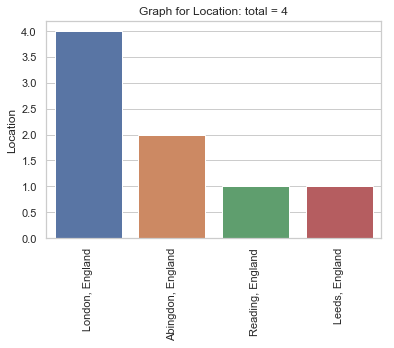

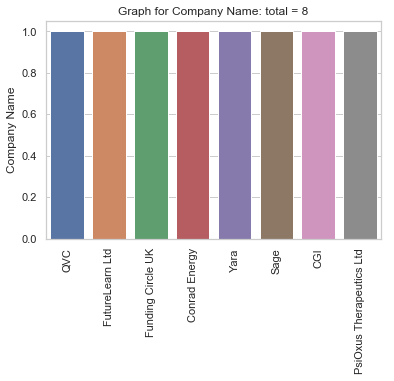

In [30]:
# Look into congested categories in more detail 
for category in df_cat[['Location', 'Company Name']].columns:
    cat_num = df_cat[category].value_counts()[:20]
    plt.figure()
    title = "Graph for %s: total = %d" % (category, len(cat_num))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_title(title)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show
   

In [36]:
# pd.pivot_table(df, index='Job Simplified', values='Average Salary')
pd.pivot_table(df, index=['Job Simplified', 'Seniority'], values='Average Salary')


Average Salary
Job Simplified Seniority                
analyst        senior               55.0
data engineer  senior               50.5
data scientist na                   56.0
               senior               51.0
na             na                   30.0
               senior               53.5

In [38]:
pd.pivot_table(df, index=['Location', 'Job Simplified'], values='Average Salary').sort_values('Average Salary', ascending=False)

Average Salary
Location          Job Simplified                
Reading, England  data scientist            57.5
Abingdon, England analyst                   55.0
                  na                        53.5
London, England   data engineer             50.5
                  data scientist            50.5
Leeds, England    na                        30.0